In [1]:
from fipy import CellVariable, FaceVariable, Grid1D, ExplicitUpwindConvectionTerm, TransientTerm
from fipy import VanLeerConvectionTerm, UpwindConvectionTerm
from fipy import ExplicitDiffusionTerm
from fipy.solvers.petsc import LinearCGSSolver
from library import ExplicitDownwindConvectionTerm
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
dx = 5e-3
dt = 2e-3
D = 3e-3
mesh = Grid1D(dx=dx, nx=200)

In [3]:
x = mesh.cellCenters.numericValue[0]
u = FaceVariable(mesh, 'velocity', rank=1, value=1.5)
u_LW = CellVariable(mesh, 'velocity', value=1.5)
u_LW = u_LW*u_LW*dt/2.0
c_init = CellVariable(mesh, 'solute', value=0.0)

In [4]:
def initialize(c):
    c.numericValue[:] = 0.0
    ind = np.logical_and(x > 0.1, x < 0.2)
    c.numericValue[ind] = 1.0
    c.faceGrad.constrain(0.0, mesh.facesRight)

In [5]:
initialize(c_init)
c_list = []

for i in range(3):
    c_list.append(CellVariable(mesh, 'Concentration', value=0.0))

In [6]:
eq_list = []
schemes = ['explicit-upwind', 'van Leer', 'Lax--Wendroff']
eq_list.append(TransientTerm(var=c_list[0]) + ExplicitUpwindConvectionTerm(coeff=u, var=c_list[0]))
eq_list.append(TransientTerm(var=c_list[1]) + VanLeerConvectionTerm(coeff=u, var=c_list[1]))
eq_list.append(TransientTerm(var=c_list[2])
               + 0.5*ExplicitUpwindConvectionTerm(coeff=u, var=c_list[2])
               + 0.5*ExplicitDownwindConvectionTerm(coeff=u, var=c_list[2])
               - ExplicitDiffusionTerm(coeff=u_LW.arithmeticFaceValue, var=c_list[2]))
#                - 0.5*ExplicitDiffusionTerm(coeff=D, var=c_list[2])
#                - 0.5*ImplicitDiffusionTerm(coeff=D, var=c_list[2]))

In [7]:
c_plot = []
for eq, c in zip(eq_list, c_list):
    initialize(c)
    for _ in range(120):
        eq.solve(var=c, dt=dt, solver=LinearCGSSolver(precon='jacobi'))
    c_plot.append(c.numericValue)

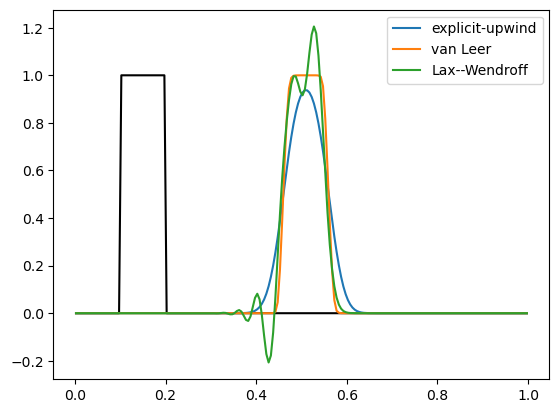

In [8]:
plt.figure()
plt.plot(x, c_init.numericValue, c='k')
for cp, scheme in zip(c_plot, schemes):
    plt.plot(x, cp, label=scheme)
plt.legend()
plt.show()